In [2]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm


from unet import UNet
from Diffusion import DenoiseDiffusion



In [3]:
def setup_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def setup_configuration():
    return { "image_size": 128,
        "image_channels": 1,
        "n_channels": 64,
        "channel_multipliers": [1, 2, 2, 4],
        "is_attention": [False, True, True, True], #changed from False, False, False, True for better results
        "n_steps": 1000,
        "batch_size": 20,
        "n_samples": 16,
        "learning_rate": 1e-5,
        "epochs": 20
        }

In [4]:
def setup_models_and_optimizer(config, device):
    eps_model = UNet(
        image_channels=config["image_channels"],
        n_channels=config["n_channels"],
        ch_mults=config["channel_multipliers"],
        is_attn=config["is_attention"]
    ).to(device)

    diffusion_model = DenoiseDiffusion(
        eps_model=eps_model,
        n_steps=config["n_steps"],
        device=device
    )

    optimizer = torch.optim.Adam(eps_model.parameters(), lr=config["learning_rate"])

    return eps_model, diffusion_model, optimizer




In [5]:
# device = setup_device()
# eps_model = UNet(
#         image_channels=config["image_channels"],
#         n_channels=config["n_channels"],
#         ch_mults=config["channel_multipliers"],
#         is_attn=config["is_attention"]
#     ).to(device)

In [6]:
# num_params = sum(p.numel() for p in eps_model.parameters() if p.requires_grad)
# print(f"Number of trainable parameters: {num_params}")

In [7]:
import os
import numpy as np

directory = '../../01_EDA/Samples'
numpy_list = []

for file_name in os.listdir(directory):
    if file_name.endswith('.npy'):
        file_path = os.path.join(directory, file_name)
        image_np = np.load(file_path)

        # Assuming the loaded image shape is (1, 150, 150), i.e., grayscale with a single channel
        # if image_np.shape == (1, 150, 150):
        #     # Remove the channel dimension
        #     image_np = np.squeeze(image_np, axis=0)
        #     # Convert grayscale to RGB by repeating the single channel 3 times
        #     image_np = np.repeat(image_np[np.newaxis, :, :], 3, axis=0)

        # Append the RGB numpy array directly to the list
        numpy_list.append(image_np)

# Now, `numpy_list` contains all your images as numpy arrays of shape (3, 150, 150)


In [8]:
numpy_list

[array([[[0.00886076, 0.01012658, 0.00506329, ..., 0.00632911,
          0.01265823, 0.01898734],
         [0.01139241, 0.01772152, 0.00886076, ..., 0.0164557 ,
          0.02025316, 0.01265823],
         [0.01139241, 0.01265823, 0.01012658, ..., 0.01012658,
          0.01265823, 0.01392405],
         ...,
         [0.01898734, 0.00759494, 0.01898734, ..., 0.01392405,
          0.01518987, 0.00886076],
         [0.01898734, 0.0164557 , 0.00506329, ..., 0.01139241,
          0.01392405, 0.00759494],
         [0.01518987, 0.01012658, 0.0164557 , ..., 0.01012658,
          0.01772152, 0.00759494]]]),
 array([[[0.00553097, 0.01106195, 0.01438053, ..., 0.01216814,
          0.00663717, 0.00995575],
         [0.01106195, 0.01216814, 0.01106195, ..., 0.01106195,
          0.01216814, 0.01106195],
         [0.01659292, 0.00995575, 0.01327434, ..., 0.01438053,
          0.00442478, 0.00884956],
         ...,
         [0.00995575, 0.01548673, 0.01216814, ..., 0.01327434,
          0.01438053, 0.

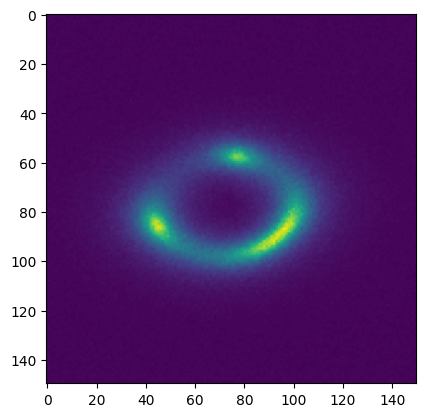

In [9]:
import matplotlib.pyplot as plt
import numpy as np

data = np.load('../../01_EDA/Samples/sample1.npy')

data = data.squeeze()
plt.imshow(data)
plt.show()



In [10]:
numpy_list = np.array(numpy_list)
print(numpy_list.shape)

(10000, 1, 150, 150)


In [ ]:
import torch

# Convert the numpy arrays to PyTorch tensors
tensor_list = [torch.tensor(image_np, dtype=torch.float32) for image_np in numpy_list]

# Normalize the tensors to have values between 0 and 1 if they aren't already
# tensor_list = [tensor / 255. for tensor in tensor_list]

In [ ]:

from torchvision.transforms import functional as TF

transformed_tensors = []
image_size = (128, 128)

for img in tensor_list:
        # Ensure img is C x H x W
    img = TF.resize(img, image_size)
    transformed_tensors.append(img)

# Stack transformed images into a single tensor
transformed_data_tensor = torch.stack(transformed_tensors)

In [ ]:
np.array(transformed_data_tensor).shape

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'transformed_data_tensor' is your tensor with shape [N, 1, 150, 150]
# where N is the number of images in the batch
# And you want to plot the first image in the batch

image_to_plot = transformed_data_tensor[0].squeeze()  # Remove channel dimension, resulting in [150, 150]

plt.imshow(image_to_plot, cmap='gray')  # Use the 'gray' colormap for grayscale images
plt.colorbar()  # Optionally add a colorbar to see the mapping from pixel values to colors
plt.show()


In [ ]:
# def load_npy_data(file_path):
#     # Load the numpy file
#     data_numpy = np.load(file_path)
#     # Convert the numpy array to a PyTorch tensor and normalize it
#     data_tensor = torch.from_numpy(data_numpy).float() / 255.0  # Normalize to [0, 1]
#     return data_tensor


def setup_dataloader(config, data_tensor):

    # data_tensor = torch.stack(data_tensor)
    labels = torch.zeros(data_tensor.size(0), dtype=torch.long)
    
    # Wrap the data and labels in a TensorDataset
    dataset = TensorDataset(data_tensor, labels)

    # Define a transform
    # transform = transforms.Compose([
    #     transforms.Resize(config["image_size"]),
    #      # If your data is already a Tensor, this is unnecessary
    # ])
    
    # DataLoader doesn't directly apply transformations to TensorDataset,
    # so you might apply transformations on-the-fly within your training loop, or modify the data beforehand
    
    # Create the DataLoader
    dataloader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)
    
    return dataloader

In [ ]:
def train(epochs, data_loader, eps_model, diffusion_model, optimizer, device):
    for epoch in range(epochs):
        eps_model.train()  # Set U-Net to training mode
        total_loss = 0.0
        # Initialize tqdm progress bar
        with tqdm(enumerate(data_loader), total=len(data_loader), desc=f'Epoch {epoch+1}/{epochs}') as pbar:
            for batch_idx, (data, _) in pbar:
                data = data.to(device)
                optimizer.zero_grad()
                loss = diffusion_model.loss(data)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                # Update tqdm postfix to display the running average loss
                pbar.set_postfix({'loss': f'{total_loss / (batch_idx + 1):.4f}'})
        
        # Print average loss for the epoch
        avg_loss = total_loss / len(data_loader)
        print(f'End of Epoch {epoch+1}, Average Loss: {avg_loss:.4f}\n')

# New Train (with validation)

In [ ]:
# import torch
# import os
# from tqdm import tqdm
# from torch.optim.lr_scheduler import StepLR

# def train(epochs, data_loader, validation_loader, eps_model, diffusion_model, optimizer, device, checkpoint_dir='checkpoints'):
#     best_validation_loss = float('inf')
#     patience = 5  # Number of epochs to wait for improvement
#     patience_counter = 0

#     scheduler = StepLR(optimizer, step_size=1, gamma=0.97)

#     for epoch in range(epochs):
#         eps_model.train()
#         total_loss = 0.0
        
#         with tqdm(enumerate(data_loader), total=len(data_loader), desc=f'Epoch {epoch+1}/{epochs}') as pbar:
#             for batch_idx, (data, _) in pbar:
#                 data = data.to(device)
#                 optimizer.zero_grad()
#                 loss = diffusion_model.loss(data)
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(eps_model.parameters(), max_norm=1.0)
#                 optimizer.step()

#                 total_loss += loss.item()
#                 pbar.set_postfix({'loss': f'{total_loss / (batch_idx + 1):.4f}'})

#         scheduler.step()

#         avg_loss = total_loss / len(data_loader)
#         print(f'End of Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')

#         # Validation
#         eps_model.eval()
#         validation_loss = 0.0
#         with torch.no_grad():
#             for data, _ in validation_loader:
#                 data = data.to(device)
#                 loss = diffusion_model.loss(data)
#                 validation_loss += loss.item()
#         avg_validation_loss = validation_loss / len(validation_loader)
#         print(f'Validation Loss: {avg_validation_loss:.4f}')

#         # Early Stopping and Checkpointing
#         if avg_validation_loss < best_validation_loss:
#             best_validation_loss = avg_validation_loss
#             patience_counter = 0
#             torch.save({
#                 'epoch': epoch + 1,
#                 'model_state_dict': eps_model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': avg_loss,
#                 'val_loss': avg_validation_loss,
#             }, os.path.join(checkpoint_dir, 'best_model.pth'))
#             print('Checkpoint saved.')
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print("Stopping early due to lack of improvement.")
#                 break

#     print("Training completed.")

# # Example usage:
# # Assuming eps_model, diffusion_model, optimizer, and device are already defined and initialized
# # Make sure to define your own data_loader and validation_loader
# # train(epochs, data_loader, validation_loader, eps_model, diffusion_model, optimizer, device)


In [ ]:
# def sample(n_samples, image_size, image_channels, diffusion_model, device, save_dir='generated_images'):
#     os.makedirs(save_dir, exist_ok=True)
#     with torch.no_grad():
#         x = torch.randn([n_samples, image_channels, image_size, image_size], device=device)
#         for t in reversed(range(diffusion_model.n_steps)):
#             x = diffusion_model.p_sample(x, torch.full((n_samples,), t, device=device, dtype=torch.long))
        
#         for i, image in enumerate(x):
#             save_path = os.path.join(save_dir, f'generated_image_{i}.npy')
#             save_image((image + 1) / 2, save_path)  # Normalize image to [0, 1]

#         print(f'Generated images have been saved to {save_dir}/')

import os
import torch
import numpy as np

def sample(n_samples, image_size, image_channels, diffusion_model, device, save_dir='generated_images_npy_FTTT'):
    os.makedirs(save_dir, exist_ok=True)
    with torch.no_grad():
        x = torch.randn([n_samples, image_channels, image_size, image_size], device=device)
        for t in reversed(range(diffusion_model.n_steps)):
            x = diffusion_model.p_sample(x, torch.full((n_samples,), t, device=device, dtype=torch.long))
        
        for i, image in enumerate(x):
            save_path = os.path.join(save_dir, f'generated_image_{i}.npy')
            # Convert the image tensor to numpy array
            # Ensure the tensor is moved to 'cpu' and converted to 'numpy' format
            image_np = image.cpu().numpy()
            # Save the numpy array to .npy format
            np.save(save_path, image_np)

    print(f'Generated images have been saved to {save_dir}/')


In [ ]:

device = setup_device()
config = setup_configuration()
eps_model, diffusion_model, optimizer = setup_models_and_optimizer(config, device)
data_loader = setup_dataloader(config,data_tensor=transformed_data_tensor)

print("Starting training...")
train(config["epochs"], data_loader,eps_model, diffusion_model, optimizer,device)



In [ ]:
print("Generating images...")
sample(config["n_samples"], config["image_size"], config["image_channels"], diffusion_model, device)

In [39]:
eps_model_path = '../../04_data_models/eps_model_noised.pth'
diffusion_model_path = '../../04_data_models/diffusion_model_FTTT.pth'

# # # Save eps_model
torch.save(eps_model.state_dict(), eps_model_path)
# # Save diffusion_model
# diffusion_model.save_model(diffusion_model_path)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = np.load("./generated_images_npy_FTTT/generated_image_0.npy")
data = np.squeeze(data)
plt.imshow(data, cmap='gray')
plt.colorbar()  # To show the scale of the image
plt.title("Simulated NPY Image")
plt.show()